In [1]:
"""
This is an investigation code. It will be executed as a py file in CleanDatasetPackage folder.
"""
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import ttest_ind
from scipy.stats import zscore

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# df1 is dataset for the first month
df1 = pd.read_parquet('drive/MyDrive/data1.parquet')
df1.rename(columns={'airport_fee': 'Airport_fee'}, inplace=True)

In [4]:
df1["duration"] = df1["tpep_pickup_datetime"] - df1["tpep_dropoff_datetime"]

In [5]:
df_imputed = df1.copy()

## For test purpose, impute passenger count with median

In [6]:
df_imputed.passenger_count.fillna(df_imputed.passenger_count.median(), inplace=True)
df1.passenger_count.fillna(df1.passenger_count.median(), inplace=True)

### Method 1 : Using Isolation Forest to identify passenger_count outliers and using Quantile based flooring and capping to impute outliers

In [8]:
def isolated_forest_and_quantile(df):
    features = ['passenger_count']
    # Create an Isolation Forest model with contamination set to 0.05 (5% of data are expected to be outliers)
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05)
    iso_forest.fit(df[features])
    # Predict the outliers using the model
    outliers = iso_forest.predict(df[features])
    outlier_mask = outliers == -1
    outliers_data = df[outlier_mask]
    mask = df.isin(outliers_data.to_dict('list')).all(axis=1)

    # flooring and capping
    floor = min(df.loc[~mask, 'passenger_count'].unique())
    cap = max(df.loc[~mask, 'passenger_count'].unique())
    df.loc[mask, 'passenger_count'] = df.loc[mask, 'passenger_count'].clip(lower=floor, upper=cap)
    return df

df_imputed = isolated_forest_and_quantile(df_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [9]:
df1.passenger_count.value_counts()

1.0    2333143
2.0     451536
3.0     106353
4.0      53745
0.0      51164
5.0      42681
6.0      28124
8.0         13
7.0          6
9.0          1
Name: passenger_count, dtype: int64

In [10]:
df_imputed.passenger_count.value_counts()

1.0    2384307
2.0     451536
4.0     124570
3.0     106353
Name: passenger_count, dtype: int64

So 0, 5, 6, 7, 8, 9 are outliers

In [11]:
df1.passenger_count.describe()

count    3.066766e+06
mean     1.354051e+00
std      8.872699e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [12]:
df_imputed.passenger_count.describe()

count    3.066766e+06
mean     1.338452e+00
std      7.327870e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+00
Name: passenger_count, dtype: float64

as we can see, the outliers from z-score and Isolation forest are quite similar.

### Test for outliers for method 1
Coefficient of variation (CV): This metric measures the ratio of the standard deviation to the mean of the target variable. A lower CV indicates less variability relative to the mean, which can be a desirable outcome after outlier handling.

In [13]:
passenger_counts = df1['passenger_count'].values
mean = np.mean(passenger_counts)
std_dev = np.std(passenger_counts)

# Calculate the coefficient of variation
cv = (std_dev / mean) * 100

print("Coefficient of variation:", cv)


Coefficient of variation: 65.52704735504582


In [14]:
passenger_counts = df_imputed['passenger_count'].values
mean = np.mean(passenger_counts)
std_dev = np.std(passenger_counts)

# Calculate the coefficient of variation
cv = (std_dev / mean) * 100

print("Coefficient of variation:", cv)


Coefficient of variation: 54.74884675735313


In [15]:
df_imputed = df1.copy()

### Method 2 : Using Z-score to identify outliers and Quantile based flooring and capping to impute outliers

In [16]:
df_imputed.passenger_count.value_counts()

1.0    2333143
2.0     451536
3.0     106353
4.0      53745
0.0      51164
5.0      42681
6.0      28124
8.0         13
7.0          6
9.0          1
Name: passenger_count, dtype: int64

In [17]:
df_imputed['zscore'] = zscore(df_imputed['passenger_count'])
outliers_mask = (df_imputed['zscore'] > 4) | (df_imputed['zscore'] < -4)
outliers = df_imputed.loc[outliers_mask, 'passenger_count']

In [18]:
outliers.unique()

array([5., 6., 8., 7., 9.])

In [19]:
floor = min(df_imputed.loc[~outliers_mask, 'passenger_count'].unique())
cap = max(df_imputed.loc[~outliers_mask, 'passenger_count'].unique())
df_imputed.loc[outliers_mask, 'passenger_count'] = outliers.clip(lower=floor, upper=cap)

In [20]:
df_imputed.passenger_count.value_counts()

1.0    2333143
2.0     451536
4.0     124570
3.0     106353
0.0      51164
Name: passenger_count, dtype: int64

So 5, 6, 7, 8, 9 are outliers

In [21]:
df1.passenger_count.describe()

count    3.066766e+06
mean     1.354051e+00
std      8.872699e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [22]:
df_imputed.passenger_count.describe()

count    3.066766e+06
mean     1.321768e+00
std      7.514485e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+00
Name: passenger_count, dtype: float64

the description of passenger_count with ouliers and passenger_count without outliers are similar. So our data isn't biased.

### CounterPlot of dataset before outlier handling

Text(0.5, 1.0, 'Count Plot of Passenger Count')

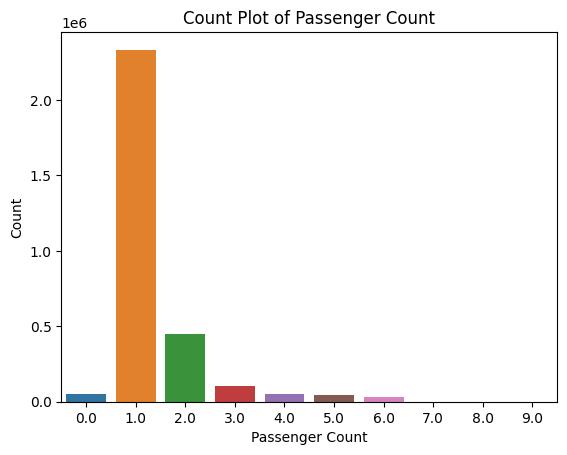

In [30]:
sns.countplot(x="passenger_count", data=df1)

plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.title("Count Plot of Passenger Count")

### CounterPlot of dataset after outlier handling

Text(0.5, 1.0, 'Count Plot of Passenger Count')

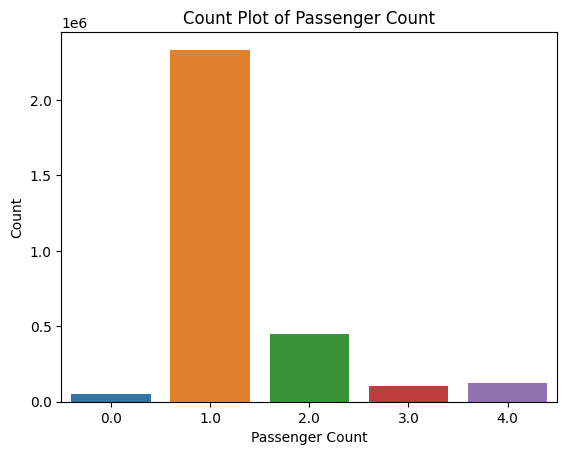

In [28]:
sns.countplot(x="passenger_count", data=df_imputed)

plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.title("Count Plot of Passenger Count")

### Test for outliers for method 2

In [25]:
passenger_counts = df1['passenger_count'].values
mean = np.mean(passenger_counts)
std_dev = np.std(passenger_counts)

# Calculate the coefficient of variation
cv = (std_dev / mean) * 100

print("Coefficient of variation:", cv)

Coefficient of variation: 65.52704735504582


In [26]:
passenger_counts = df_imputed['passenger_count'].values
mean = np.mean(passenger_counts)
std_dev = np.std(passenger_counts)

# Calculate the coefficient of variation
cv = (std_dev / mean) * 100

print("Coefficient of variation:", cv)

Coefficient of variation: 56.85174657541863


### Result
method 1(isolation forest) got less std and less CV. So I will use that as my main algorithm.

### Handling RateCodeID outlier

In [27]:
df_imputed.RatecodeID.value_counts()  # get 99 ratecodeid as an unknown ratecodeid. we won't change it, because it could get biased and won't recognize test data.

1.0     2839305
2.0      114239
5.0       15043
99.0      13106
3.0        8958
4.0        4366
6.0           6
Name: RatecodeID, dtype: int64